In [2]:
import datetime

# Fecha adelantada 24 horas
def asignar_fecha(row, columna):
    nueva_fecha = row[columna] + datetime.timedelta(hours=24)
    return nueva_fecha


# Conversión de unidades de microgramo/metro_cúbico a ppb(partículas por billón)
def convertir_ppb(row, columna):
    ppb = row[columna] / 1.96
    return ppb


# Cálculo del índice de calidad del aire para el PM10 (usando datos en microgramo/metro_cúbico)
def indice_PM10(row):
    if row >= 0 and row <= 40:
        indice = 1.2500 * (row)
        return round(indice)
    if row >= 41 and row <= 75:
        indice = (1.4412 * (row - 41)) + 51
        return round(indice)
    if row >= 76 and row <= 214:
        indice = (0.3551 * (row - 76)) + 101
        return round(indice)
    if row >= 215 and row <= 354:
        indice = (0.3525 * (row - 215)) + 151
        return round(indice)
    if row >= 355 and row <= 424:
        indice = (1.4348 * (row - 355)) + 201
        return round(indice)
    if row >= 425 and row <= 504:
        indice = (1.2532 * (row - 425) + 301)
        return round(indice)
    if row >= 505 and row <= 604:
        indice = (1.0000 * (row - 505) + 401)
        return round(indice)


# Cálculo del índice de calidad del aire para el O3 (usando datos en ppb)
def indice_O3(row):
    if row >= 0 and row <= 70:
        indice = 0.7143 * (row)
        return round(indice)
    if row >= 71 and row <= 95:
        indice = (2.0417 * (row - 71)) + 51
        return round(indice)
    if row >= 96 and row <= 154:
        indice = (2.4138 * (row - 96)) + 101
        return round(indice)
    if row >= 155 and row <= 204:
        indice = (1.0000 * (row - 155)) + 151
        return round(indice)
    if row >= 205 and row <= 404:
        indice = (0.4975 * (row - 205)) + 201
        return round(indice)
    if row >= 405 and row <= 504:
        indice = (1.000 * (row - 405) + 301)
        return round(indice)
    if row >= 505 and row <= 604:
        indice = (1.0000 * (row - 505) + 401)
        return round(indice)


def convertir_unidades(df, columna_fecha):
    df = df.sort_values([columna_fecha], ascending=[0])
    df['PM10mean_max_ppb'] = df.apply(lambda row: convertir_ppb(row, 'PM10mean_y'), axis=1)
    df_concentraciones = df[['fecha', 'O3_y', 'PM10mean_y_ppb', 'TMP', 'TMP_x', 'TMP_y']]

    return df_concentraciones



## Datos de contaminación

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from IPython.display import display, Math, Latex
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

In [4]:
df = pd.read_csv("/Users/danielbustillos/Documents/CONACyT/Marginación_contaminación/datos_estaciones/datos_estacion.csv")

In [5]:
df.head()

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2,TMP,UVA,WSP,dia,fecha,hora,id_station,mes
0,1.5,23.0,30.0,54.0,2.0,127.0,NaN,NaN,6.0,11.0,NaN,0.7,1,2013-01-01 01:00:00,1,ACO,1
1,1.7,76.0,30.0,106.0,1.0,72.0,55.0,17.0,7.0,NaN,NaN,NaN,1,2013-01-01 01:00:00,1,CAM,1
2,NaN,24.0,25.0,48.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,1.1,1,2013-01-01 01:00:00,1,CHO,1
3,NaN,49.0,29.0,78.0,3.0,NaN,75.0,NaN,NaN,NaN,NaN,NaN,1,2013-01-01 01:00:00,1,COY,1
4,1.4,39.0,37.0,75.0,0.0,63.0,46.0,17.0,4.0,14.5,NaN,1.0,1,2013-01-01 01:00:00,1,HGM,1


In [6]:
df.describe()

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2,TMP,UVA,WSP,dia,hora,mes
count,913276.000000,956150.000000,956170.000000,956170.000000,1.177491e+06,727408.000000,546796.000000,370157.000000,1.026163e+06,724248.000000,288990.000000,749284.000000,1.177491e+06,1.177491e+06,1.177491e+06
mean,0.685609,18.869642,25.672015,44.539011,2.890505e+01,44.935945,23.435058,21.807465,4.683572e+00,16.416319,0.788095,2.075425,1.571186e+01,1.164439e+01,6.507060e+00
std,0.509925,33.069189,14.297294,41.336828,2.692942e+01,31.372068,16.280676,18.011598,9.504144e+00,4.969714,1.450318,1.223336,8.800115e+00,6.880402e+00,3.412420e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.000000,0.000000e+00,-5.500000,0.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00
25%,0.400000,2.000000,15.000000,19.000000,7.000000e+00,23.000000,12.000000,10.000000,1.000000e+00,13.200000,0.000000,1.200000,8.000000e+00,6.000000e+00,4.000000e+00
50%,0.600000,6.000000,23.000000,32.000000,2.100000e+01,38.000000,20.000000,18.000000,2.000000e+00,16.100000,0.000000,1.800000,1.600000e+01,1.200000e+01,7.000000e+00
75%,0.900000,20.000000,33.000000,55.000000,4.400000e+01,58.000000,31.000000,28.000000,4.000000e+00,19.900000,0.879000,2.600000,2.300000e+01,1.800000e+01,9.000000e+00
max,10.000000,688.000000,190.000000,755.000000,2.100000e+02,1023.000000,988.000000,666.000000,4.000000e+02,34.100000,7.828000,14.100000,3.100000e+01,2.300000e+01,1.200000e+01


Hacemos una columna de año:

In [7]:
df["anio"] = df.fecha.str[0:4]
df.anio = df.anio.astype(int)

## Documento Metodología:

In [8]:
df_gb = df.groupby("hora")["PM10","O3","PM2.5","TMP","UVA","mes","dia"].mean()
df_gb.reset_index(inplace=True)
df_gb.dropna(inplace=True)

In [9]:
df_gb.head()

,hora,PM10,O3,PM2.5,TMP,UVA,mes,dia
0,0,35.432037,14.332939,18.831870,14.361336,0.0,6.501223,15.695592
1,1,33.976205,13.833893,19.496199,13.814584,0.0,6.470754,15.706335
2,2,32.711729,13.433546,19.814392,13.285075,0.0,6.471766,15.707524
3,3,31.786243,12.685927,19.796937,12.799126,0.0,6.466206,15.715411
4,4,32.224867,11.441953,20.165470,12.374863,0.0,6.525529,15.729302


In [10]:
df_gb.describe()

,hora,PM10,O3,PM2.5,TMP,UVA,mes,dia
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,11.500000,44.753036,28.799575,23.407891,16.365464,0.781021,6.506561,15.711763
std,7.071068,8.857591,21.730533,4.546959,3.700029,1.058956,0.015303,0.009054
min,0.000000,31.786243,4.960165,18.831870,11.443838,0.000000,6.466206,15.695592
25%,5.750000,37.158434,12.887850,19.753926,13.163588,0.000000,6.506496,15.705872
50%,11.500000,45.233327,18.842261,21.547322,15.796933,0.068920,6.511361,15.710805
75%,17.250000,49.985010,46.652123,26.511811,19.683820,1.548649,6.512778,15.716814
max,23.000000,60.642853,68.404863,33.009168,22.182064,2.906188,6.527062,15.729302


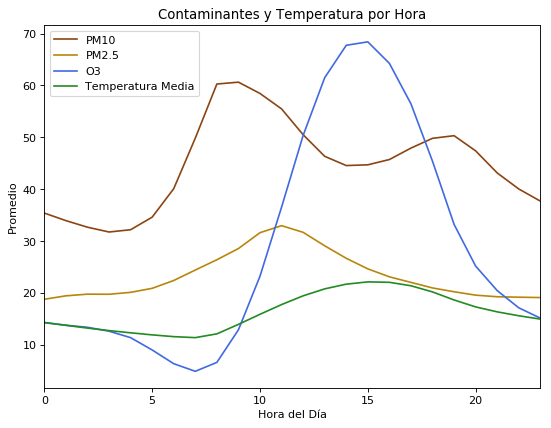

In [37]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
ax = fig.gca()

df_gb.plot(x="hora", y="PM10",color="saddlebrown",ax=ax)
df_gb.plot(x="hora", y="PM2.5",ax=ax,color='darkgoldenrod')
df_gb.plot(x="hora", y="O3",ax=ax,color='royalblue')
df_gb.plot(x="hora", y="TMP",ax=ax,color='forestgreen',label="Temperatura Media")




ax.set_title('Contaminantes y Temperatura por Hora')
ax.set_ylabel('Promedio')
ax.set_xlabel('Hora del Día')


plt.legend()
plt.show()

In [42]:
df_gb = df.groupby("mes")["PM10","PM2.5","O3","TMP","UVA"].mean()
df_gb.reset_index(inplace=True)
df_gb.dropna(inplace=True)

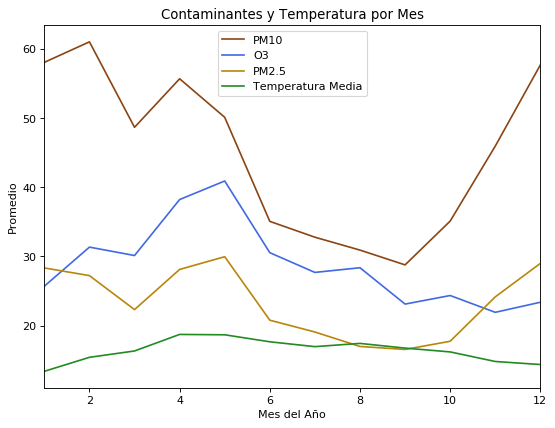

In [43]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
ax = fig.gca()

df_gb.plot(x="mes", y="PM10",color="saddlebrown",ax=ax)
df_gb.plot(x="mes", y="O3",ax=ax,color='royalblue')
df_gb.plot(x="mes", y="PM2.5",ax=ax,color='darkgoldenrod')

df_gb.plot(x="mes", y="TMP",ax=ax,color='forestgreen',label="Temperatura Media")




ax.set_title('Contaminantes y Temperatura por Mes')
ax.set_ylabel('Promedio')
ax.set_xlabel('Mes del Año')


plt.legend()
plt.show()

In [9]:
ax = sns.scatterplot(x="hora", y="tip", hue="time",data=df_melted)

NameError: name 'df_melted' is not defined

## convertimos a indice:

In [ ]:
df['O3_index'] = df['O3'].apply(indice_O3)
df['PM10_index'] = df['PM10'].apply(indice_O3)

In [ ]:
df